In [174]:
# Cell 1: Importações e configuração
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')


In [175]:
# Cell 2: Carregamento e preparação dos dados
print("=== Loading DATASET MNIST ===")
try:
    import tensorflow as tf
    (X_treino, y_treino), (X_teste, y_teste) = tf.keras.datasets.mnist.load_data()
    print("Dataset carregado via TensorFlow")
except:
    print("Creating synthetic data for demonstration")
    np.random.seed(42)
    X_treino = np.random.randint(0, 256, (6000, 28, 28), dtype=np.uint8)
    y_treino = np.random.randint(0, 10, 6000)
    X_teste = np.random.randint(0, 256, (1000, 28, 28), dtype=np.uint8)
    y_teste = np.random.randint(0, 10, 1000)

# Pré-processamento
X_treino = X_treino.reshape(-1, 784).astype(np.float32) / 255.0
X_teste = X_teste.reshape(-1, 784).astype(np.float32) / 255.0

enc = OneHotEncoder(sparse_output=False)
y_treino_one_hot = enc.fit_transform(y_treino.reshape(-1, 1))
y_teste_one_hot = enc.transform(y_teste.reshape(-1, 1))

X_treino_split, X_validacao, y_treino_split, y_validacao = train_test_split(
    X_treino, y_treino_one_hot, test_size=0.2, random_state=42
)

print(f"Train: {X_treino_split.shape}, Validation: {X_validacao.shape}, Test: {X_teste.shape}")

=== Loading DATASET MNIST ===
Creating synthetic data for demonstration
Train: (4800, 784), Validation: (1200, 784), Test: (1000, 784)


In [176]:
# Cell 3: Classe para Mini-Batches
class GeradorMiniBatch:
    """Gerador de mini-lotes para treinamento"""
    def __init__(self, X, y, tamanho_lote=32, seed=0):
        self.tamanho_lote = tamanho_lote
        np.random.seed(seed)
        indice_embaralhado = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[indice_embaralhado]
        self._y = y[indice_embaralhado]
        self._parada = int(np.ceil(X.shape[0]/self.tamanho_lote))

    def __len__(self):
        return self._parada

    def __getitem__(self, item):
        p0 = item * self.tamanho_lote
        p1 = item * self.tamanho_lote + self.tamanho_lote
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._contador = 0
        return self

    def __next__(self):
        if self._contador >= self._parada:
            raise StopIteration()
        p0 = self._contador * self.tamanho_lote
        p1 = self._contador * self.tamanho_lote + self.tamanho_lote
        self._contador += 1
        return self._X[p0:p1], self._y[p0:p1]

In [177]:
# Cell 4: Métodos de Inicialização de Pesos
class InicializadorSimples:
    """Inicialização simples com distribuição Gaussiana"""
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, n_nos1, n_nos2):
        return self.sigma * np.random.randn(n_nos1, n_nos2)
    
    def B(self, n_nos2):
        return np.zeros(n_nos2)

class InicializadorXavier:
    """Inicialização de Xavier/Glorot para tanh/sigmoid"""
    def W(self, n_nos1, n_nos2):
        sigma = np.sqrt(1.0 / n_nos1)
        return np.random.uniform(-sigma, sigma, (n_nos1, n_nos2))
    
    def B(self, n_nos2):
        return np.zeros(n_nos2)

class InicializadorHe:
    """Inicialização de He para ReLU"""
    def W(self, n_nos1, n_nos2):
        sigma = np.sqrt(2.0 / n_nos1)
        return np.random.randn(n_nos1, n_nos2) * sigma
    
    def B(self, n_nos2):
        return np.zeros(n_nos2)

In [178]:
# Cell 5: Métodos de Otimização
class SGD:
    """Descida de Gradiente Estocástica"""
    def __init__(self, taxa_aprendizado=0.01):
        self.taxa_aprendizado = taxa_aprendizado
        
    def atualizar(self, camada):
        camada.W -= self.taxa_aprendizado * camada.dW
        camada.B -= self.taxa_aprendizado * camada.dB
        return camada

class AdaGrad:
    """Otimizador AdaGrad"""
    def __init__(self, taxa_aprendizado=0.01, epsilon=1e-8):
        self.taxa_aprendizado = taxa_aprendizado
        self.epsilon = epsilon
        self.H_w = None
        self.H_b = None
        
    def atualizar(self, camada):
        if self.H_w is None:
            self.H_w = np.zeros_like(camada.W)
            self.H_b = np.zeros_like(camada.B)
            
        self.H_w += camada.dW ** 2
        self.H_b += camada.dB ** 2
        
        camada.W -= self.taxa_aprendizado * camada.dW / (np.sqrt(self.H_w) + self.epsilon)
        camada.B -= self.taxa_aprendizado * camada.dB / (np.sqrt(self.H_b) + self.epsilon)
        
        return camada

In [179]:
# Cell 6: Funções de Ativação
class Tanh:
    """Função de ativação Tangente Hiperbólica"""
    def forward(self, x):
        self.x = x
        return np.tanh(x)
    
    def backward(self, dout):
        return dout * (1 - np.tanh(self.x)**2)

class Sigmoid:
    """Função de ativação Sigmoid"""
    def forward(self, x):
        self.x = x
        self.saida = 1 / (1 + np.exp(-np.clip(x, -250, 250)))
        return self.saida
    
    def backward(self, dout):
        return dout * self.saida * (1 - self.saida)

class ReLU:
    """Função de ativação ReLU"""
    def forward(self, x):
        self.mascara = (x <= 0)
        saida = x.copy()
        saida[self.mascara] = 0
        return saida
    
    def backward(self, dout):
        dout[self.mascara] = 0
        return dout

class SoftmaxComPerda:
    """Softmax combinado com perda de entropia cruzada"""
    def forward(self, x, y_verdadeiro=None):
        x_deslocado = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x_deslocado)
        self.y_predito = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        
        if y_verdadeiro is not None:
            self.y_verdadeiro = y_verdadeiro
            epsilon = 1e-8
            self.y_predito = np.clip(self.y_predito, epsilon, 1 - epsilon)
            self.perda = -np.sum(y_verdadeiro * np.log(self.y_predito)) / x.shape[0]
            return self.perda
        return self.y_predito
    
    def backward(self):
        return (self.y_predito - self.y_verdadeiro) / self.y_verdadeiro.shape[0]

In [180]:
# Cell 7: Camada Fully Connected
class CamadaTotalmenteConectada:
    """Camada totalmente conectada"""
    def __init__(self, n_nos1, n_nos2, inicializador, otimizador):
        self.otimizador = otimizador
        self.W = inicializador.W(n_nos1, n_nos2)
        self.B = inicializador.B(n_nos2)
        
    def forward(self, X):
        self.X = X
        return X @ self.W + self.B
    
    def backward(self, dA):
        tamanho_lote = self.X.shape[0]
        
        self.dW = self.X.T @ dA / tamanho_lote
        self.dB = np.sum(dA, axis=0) / tamanho_lote
        
        dZ = dA @ self.W.T
        
        self = self.otimizador.atualizar(self)
        
        return dZ

In [181]:
# Cell 8: Rede Neural Profunda Modular (CORRIGIDA)
class ClassificadorRedeNeuralProfunda:
    """Rede Neural Profunda Modular - VERSÃO CORRIGIDA"""
    def __init__(self, configuracao_camadas, verbose=True):
        self.configuracao_camadas = configuracao_camadas
        self.verbose = verbose
        self.camadas = []
        self.ativacoes = []
        
    def _construir_rede(self, n_caracteristicas):
        self.camadas = []
        self.ativacoes = []
        
        n_anterior = n_caracteristicas
        
        for i, (tipo_camada, n_nos, ativacao, inicializador, otimizador) in enumerate(self.configuracao_camadas):
            if tipo_camada == 'FC':
                camada = CamadaTotalmenteConectada(n_anterior, n_nos, inicializador, otimizador)
                self.camadas.append(camada)
                
                if ativacao == 'tanh':
                    self.ativacoes.append(Tanh())
                elif ativacao == 'sigmoid':
                    self.ativacoes.append(Sigmoid())
                elif ativacao == 'relu':
                    self.ativacoes.append(ReLU())
                elif ativacao == 'softmax':
                    self.ativacoes.append(SoftmaxComPerda())
                
                n_anterior = n_nos
        
        if self.verbose:
            print(f"Rede construída com {len(self.camadas)} camadas")
            for i, camada in enumerate(self.camadas):
                print(f"Camada {i+1}: {camada.W.shape[0]} → {camada.W.shape[1]} nós")
    
    def fit(self, X, y, X_val=None, y_val=None, epocas=10, tamanho_lote=32):
        n_amostras, n_caracteristicas = X.shape
        
        self._construir_rede(n_caracteristicas)
        
        self.perda_treino = []
        self.perda_validacao = []
        self.acuracia_treino = []
        self.acuracia_validacao = []
        
        for epoca in range(epocas):
            gerador_mini_batch = GeradorMiniBatch(X, y, tamanho_lote=tamanho_lote)
            perda_epoca = 0
            contador_lotes = 0
            
            for X_lote, y_lote in gerador_mini_batch:
                # FORWARD PROPAGATION
                A = X_lote
                for camada, ativacao in zip(self.camadas, self.ativacoes):
                    A = camada.forward(A)
                    if not isinstance(ativacao, SoftmaxComPerda):
                        A = ativacao.forward(A)
                
                # Calcula loss
                perda = self.ativacoes[-1].forward(A, y_lote)
                perda_epoca += perda
                contador_lotes += 1
                
                # BACKWARD PROPAGATION - CORRIGIDO
                dA = self.ativacoes[-1].backward()
                
                # Percorre camadas na ordem inversa
                for i in range(len(self.camadas)-1, -1, -1):
                    camada = self.camadas[i]
                    
                    # Se não é a última camada, aplica backward da ativação
                    if i < len(self.ativacoes) - 1:
                        ativacao = self.ativacoes[i]
                        dA = ativacao.backward(dA)
                    
                    # Backward da camada FC
                    dA = camada.backward(dA)
            
            perda_media_epoca = perda_epoca / contador_lotes
            self.perda_treino.append(perda_media_epoca)
            
            pred_treino = self.predict(X)
            acuracia_treino = accuracy_score(np.argmax(y, axis=1), pred_treino)
            self.acuracia_treino.append(acuracia_treino)
            
            if X_val is not None and y_val is not None:
                pred_val = self.predict(X_val)
                acuracia_val = accuracy_score(np.argmax(y_val, axis=1), pred_val)
                self.acuracia_validacao.append(acuracia_val)
                
                # Calcula perda de validação
                A_val = X_val
                for camada, ativacao in zip(self.camadas, self.ativacoes):
                    A_val = camada.forward(A_val)
                    if not isinstance(ativacao, SoftmaxComPerda):
                        A_val = ativacao.forward(A_val)
                perda_val = self.ativacoes[-1].forward(A_val, y_val)
                self.perda_validacao.append(perda_val)
            
            if self.verbose and epoca % 2 == 0:
                if X_val is not None and y_val is not None:
                    print(f"Época {epoca:3d}/{epocas} | "
                          f"Perda Treino: {perda_media_epoca:.4f} | "
                          f"Perda Val: {perda_val:.4f} | "
                          f"Acuracia Treino: {acuracia_treino:.4f} | "
                          f"Acuracia Val: {acuracia_val:.4f}")
                else:
                    print(f"Época {epoca:3d}/{epocas} | "
                          f"Perda Treino: {perda_media_epoca:.4f} | "
                          f"Acuracia Treino: {acuracia_treino:.4f}")
    
    def predict(self, X):
        A = X
        for camada, ativacao in zip(self.camadas, self.ativacoes):
            A = camada.forward(A)
            if not isinstance(ativacao, SoftmaxComPerda):
                A = ativacao.forward(A)
        
        if isinstance(self.ativacoes[-1], SoftmaxComPerda):
            A = self.ativacoes[-1].forward(A)
        
        return np.argmax(A, axis=1)
    
    def predict_proba(self, X):
        A = X
        for camada, ativacao in zip(self.camadas, self.ativacoes):
            A = camada.forward(A)
            if not isinstance(ativacao, SoftmaxComPerda):
                A = ativacao.forward(A)
        
        if isinstance(self.ativacoes[-1], SoftmaxComPerda):
            A = self.ativacoes[-1].forward(A)
        
        return A

In [182]:
# Cell 9: Teste das diferentes configurações (CORRIGIDO)
print("\n" + "="*60)
print("TESTANDO DIFERENTES CONFIGURAÇÕES DE REDE")
print("="*60)

# Configuração 1: Rede Simples com Tanh
print("\n--- Configuração 1: Simples com Tanh ---")
configuracao1 = [
    ('FC', 128, 'tanh', InicializadorSimples(0.01), SGD(0.1)),
    ('FC', 64, 'tanh', InicializadorSimples(0.01), SGD(0.1)),
    ('FC', 10, 'softmax', InicializadorSimples(0.01), SGD(0.1))
]

modelo1 = ClassificadorRedeNeuralProfunda(configuracao1, verbose=True)
modelo1.fit(X_treino_split, y_treino_split, X_validacao, y_validacao, epocas=10, tamanho_lote=32)

y_predito1 = modelo1.predict(X_teste)
acuracia1 = accuracy_score(y_teste, y_predito1)
print(f"Acurácia Configuração 1: {acuracia1:.4f}")


TESTANDO DIFERENTES CONFIGURAÇÕES DE REDE

--- Configuração 1: Simples com Tanh ---
Rede construída com 3 camadas
Camada 1: 784 → 128 nós
Camada 2: 128 → 64 nós
Camada 3: 64 → 10 nós
Época   0/10 | Perda Treino: 2.3026 | Perda Val: 2.3027 | Acuracia Treino: 0.1058 | Acuracia Val: 0.0950
Época   2/10 | Perda Treino: 2.3024 | Perda Val: 2.3027 | Acuracia Treino: 0.1069 | Acuracia Val: 0.0875
Época   4/10 | Perda Treino: 2.3022 | Perda Val: 2.3027 | Acuracia Treino: 0.1069 | Acuracia Val: 0.0875


KeyboardInterrupt: 

In [ ]:
# Cell 10: Configuração 2 - ReLU + He
print("\n--- Configuração 2: ReLU + Inicialização He ---")
configuracao2 = [
    ('FC', 128, 'relu', InicializadorHe(), SGD(0.01)),
    ('FC', 64, 'relu', InicializadorHe(), SGD(0.01)),
    ('FC', 10, 'softmax', InicializadorHe(), SGD(0.01))
]

modelo2 = ClassificadorRedeNeuralProfunda(configuracao2, verbose=True)
modelo2.fit(X_treino_split, y_treino_split, X_validacao, y_validacao, epocas=10, tamanho_lote=32)

y_predito2 = modelo2.predict(X_teste)
acuracia2 = accuracy_score(y_teste, y_predito2)
print(f"Acurácia Configuração 2: {acuracia2:.4f}")


--- Configuração 2: ReLU + Inicialização He ---
Rede construída com 3 camadas
Camada 1: 784 → 128 nós
Camada 2: 128 → 64 nós
Camada 3: 64 → 10 nós
Época   0/10 | Perda Treino: 2.4697 | Perda Val: 2.4007 | Acuracia Treino: 0.0994 | Acuracia Val: 0.1067
Época   2/10 | Perda Treino: 2.3711 | Perda Val: 2.3611 | Acuracia Treino: 0.1023 | Acuracia Val: 0.1158
Época   4/10 | Perda Treino: 2.3531 | Perda Val: 2.3538 | Acuracia Treino: 0.1025 | Acuracia Val: 0.1083
Época   6/10 | Perda Treino: 2.3430 | Perda Val: 2.3500 | Acuracia Treino: 0.1040 | Acuracia Val: 0.1092
Época   8/10 | Perda Treino: 2.3362 | Perda Val: 2.3470 | Acuracia Treino: 0.1094 | Acuracia Val: 0.1133
Acurácia Configuração 2: 0.1030


In [ ]:
# Cell 11: Configuração 3 - Rede Profunda com AdaGrad
print("\n--- Configuração 3: Profunda com AdaGrad ---")
configuracao3 = [
    ('FC', 256, 'relu', InicializadorHe(), AdaGrad(0.01)),
    ('FC', 128, 'relu', InicializadorHe(), AdaGrad(0.01)),
    ('FC', 64, 'relu', InicializadorHe(), AdaGrad(0.01)),
    ('FC', 10, 'softmax', InicializadorHe(), AdaGrad(0.01))
]

modelo3 = ClassificadorRedeNeuralProfunda(configuracao3, verbose=True)
modelo3.fit(X_treino_split, y_treino_split, X_validacao, y_validacao, epocas=10, tamanho_lote=32)

y_predito3 = modelo3.predict(X_teste)
acuracia3 = accuracy_score(y_teste, y_predito3)
print(f"Acurácia Configuração 3: {acuracia3:.4f}")


--- Configuração 3: Profunda com AdaGrad ---
Rede construída com 4 camadas
Camada 1: 784 → 256 nós
Camada 2: 256 → 128 nós
Camada 3: 128 → 64 nós
Camada 4: 64 → 10 nós
Época   0/10 | Perda Treino: 2.4633 | Perda Val: 2.3188 | Acuracia Treino: 0.1029 | Acuracia Val: 0.0925
Época   2/10 | Perda Treino: 2.3015 | Perda Val: 2.3038 | Acuracia Treino: 0.1117 | Acuracia Val: 0.1033
Época   4/10 | Perda Treino: 2.2974 | Perda Val: 2.3117 | Acuracia Treino: 0.1125 | Acuracia Val: 0.0933
Época   6/10 | Perda Treino: 2.2922 | Perda Val: 2.3073 | Acuracia Treino: 0.1235 | Acuracia Val: 0.0975
Época   8/10 | Perda Treino: 2.2830 | Perda Val: 2.3095 | Acuracia Treino: 0.1354 | Acuracia Val: 0.0975
Acurácia Configuração 3: 0.0820



COMPARAÇÃO FINAL DAS CONFIGURAÇÕES
Configuração 1 (Tanh + Inicialização Simples): 0.0940
Configuração 2 (ReLU + Inicialização He): 0.1030
Configuração 3 (Profunda + AdaGrad): 0.0820


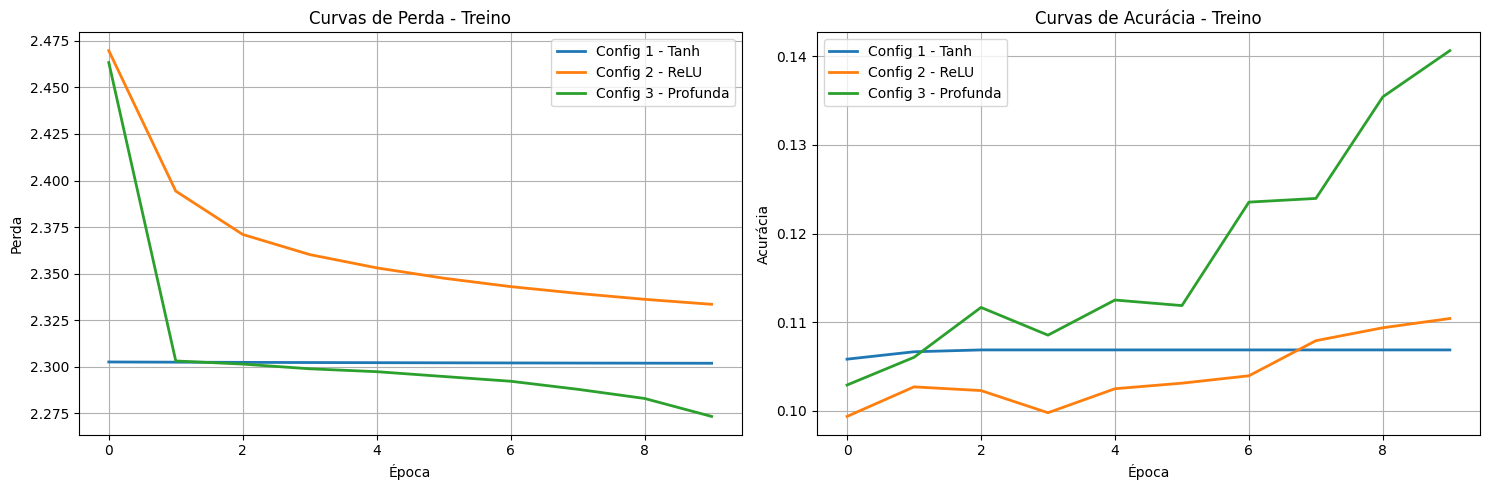

In [ ]:
# Cell 12: Comparação final e visualização
print("\n" + "="*60)
print("COMPARAÇÃO FINAL DAS CONFIGURAÇÕES")
print("="*60)
print(f"Configuração 1 (Tanh + Inicialização Simples): {acuracia1:.4f}")
print(f"Configuração 2 (ReLU + Inicialização He): {acuracia2:.4f}")
print(f"Configuração 3 (Profunda + AdaGrad): {acuracia3:.4f}")

# Visualização das curvas de aprendizado
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(modelo1.perda_treino, label='Config 1 - Tanh', linewidth=2)
plt.plot(modelo2.perda_treino, label='Config 2 - ReLU', linewidth=2)
plt.plot(modelo3.perda_treino, label='Config 3 - Profunda', linewidth=2)
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Curvas de Perda - Treino')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(modelo1.acuracia_treino, label='Config 1 - Tanh', linewidth=2)
plt.plot(modelo2.acuracia_treino, label='Config 2 - ReLU', linewidth=2)
plt.plot(modelo3.acuracia_treino, label='Config 3 - Profunda', linewidth=2)
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.title('Curvas de Acurácia - Treino')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Cell 14: Correções das Funções de Ativação e Camadas
class TanhCorrigido:
    """Tanh corrigido - guarda a saída em vez da entrada"""
    def forward(self, x):
        self.saida = np.tanh(x)
        return self.saida
    
    def backward(self, dout):
        return dout * (1 - self.saida**2)

class SigmoidCorrigido:
    """Sigmoid corrigido"""
    def forward(self, x):
        self.saida = 1 / (1 + np.exp(-np.clip(x, -250, 250)))
        return self.saida
    
    def backward(self, dout):
        return dout * self.saida * (1 - self.saida)

class ReLUCorrigido:
    """ReLU corrigido"""
    def forward(self, x):
        self.mascara = (x <= 0)
        saida = x.copy()
        saida[self.mascara] = 0
        return saida
    
    def backward(self, dout):
        dout[self.mascara] = 0
        return dout

class SoftmaxComPerdaCorrigido:
    """Softmax com perda - versão corrigida"""
    def forward(self, x, y_verdadeiro=None):
        # Softmax estável
        x_estavel = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x_estavel)
        self.y_predito = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        
        if y_verdadeiro is not None:
            self.y_verdadeiro = y_verdadeiro
            epsilon = 1e-8
            y_predito_clip = np.clip(self.y_predito, epsilon, 1 - epsilon)
            self.perda = -np.sum(y_verdadeiro * np.log(y_predito_clip)) / x.shape[0]
            return self.perda
        return self.y_predito
    
    def backward(self):
        batch_size = self.y_verdadeiro.shape[0]
        return (self.y_predito - self.y_verdadeiro) / batch_size

class CamadaTotalmenteConectadaCorrigida:
    """Camada FC corrigida com inicialização e backward apropriados"""
    def __init__(self, n_nos1, n_nos2, inicializador, otimizador):
        self.otimizador = otimizador
        self.W = inicializador.W(n_nos1, n_nos2)
        self.B = inicializador.B(n_nos2)
        
    def forward(self, X):
        self.X = X  # Guarda input para backward
        return X @ self.W + self.B
    
    def backward(self, dA):
        """
        Backward propagation corrigido
        dA: gradiente da ativação seguinte
        """
        batch_size = self.X.shape[0]
        
        # Gradientes dos pesos
        self.dW = (self.X.T @ dA) 
        self.dB = np.sum(dA, axis=0)
        
        # Gradiente para camada anterior
        dZ = dA @ self.W.T
        
        # Atualiza pesos
        self = self.otimizador.atualizar(self)
        
        return dZ

In [ ]:
# Cell 15: Rede Neural Corrigida
class ClassificadorRedeNeuralProfundaCorrigido:
    """Rede Neural Profunda - VERSÃO COMPLETAMENTE CORRIGIDA"""
    def __init__(self, configuracao_camadas, verbose=True):
        self.configuracao_camadas = configuracao_camadas
        self.verbose = verbose
        self.camadas = []
        self.ativacoes = []
        
    def _construir_rede(self, n_caracteristicas):
        self.camadas = []
        self.ativacoes = []
        
        n_anterior = n_caracteristicas
        
        for i, (tipo_camada, n_nos, ativacao, inicializador, otimizador) in enumerate(self.configuracao_camadas):
            if tipo_camada == 'FC':
                camada = CamadaTotalmenteConectadaCorrigida(n_anterior, n_nos, inicializador, otimizador)
                self.camadas.append(camada)
                
                if ativacao == 'tanh':
                    self.ativacoes.append(TanhCorrigido())
                elif ativacao == 'sigmoid':
                    self.ativacoes.append(SigmoidCorrigido())
                elif ativacao == 'relu':
                    self.ativacoes.append(ReLUCorrigido())
                elif ativacao == 'softmax':
                    self.ativacoes.append(SoftmaxComPerdaCorrigido())
                
                n_anterior = n_nos
        
        if self.verbose:
            print(f"Rede construída com {len(self.camadas)} camadas")
            for i, camada in enumerate(self.camadas):
                print(f"Camada {i+1}: {camada.W.shape[0]} → {camada.W.shape[1]} nós")
    
    def fit(self, X, y, X_val=None, y_val=None, epocas=20, tamanho_lote=64):  # Aumentado épocas
        n_amostras, n_caracteristicas = X.shape
        
        self._construir_rede(n_caracteristicas)
        
        self.perda_treino = []
        self.perda_validacao = []
        self.acuracia_treino = []
        self.acuracia_validacao = []
        
        for epoca in range(epocas):
            gerador_mini_batch = GeradorMiniBatch(X, y, tamanho_lote=tamanho_lote)
            perda_epoca = 0
            contador_lotes = 0
            
            for X_lote, y_lote in gerador_mini_batch:
                # FORWARD PROPAGATION
                A = X_lote
                self.forward_cache = []  # Guarda saídas para backward
                
                for i, (camada, ativacao) in enumerate(zip(self.camadas, self.ativacoes)):
                    A = camada.forward(A)
                    if not isinstance(ativacao, SoftmaxComPerdaCorrigido):
                        A = ativacao.forward(A)
                    self.forward_cache.append(A.copy())
                
                # Calcula loss
                perda = self.ativacoes[-1].forward(A, y_lote)
                perda_epoca += perda
                contador_lotes += 1
                
                # BACKWARD PROPAGATION - CORRIGIDO
                dA = self.ativacoes[-1].backward()
                
                # Percorre na ordem inversa
                for i in range(len(self.camadas)-1, -1, -1):
                    # Backward da ativação (exceto para a última que já foi feita)
                    if i < len(self.ativacoes) - 1:
                        dA = self.ativacoes[i].backward(dA)
                    
                    # Backward da camada
                    dA = self.camadas[i].backward(dA)
            
            perda_media_epoca = perda_epoca / contador_lotes
            self.perda_treino.append(perda_media_epoca)
            
            pred_treino = self.predict(X)
            acuracia_treino = accuracy_score(np.argmax(y, axis=1), pred_treino)
            self.acuracia_treino.append(acuracia_treino)
            
            if X_val is not None and y_val is not None:
                pred_val = self.predict(X_val)
                acuracia_val = accuracy_score(np.argmax(y_val, axis=1), pred_val)
                self.acuracia_validacao.append(acuracia_val)
                
                # Calcula perda de validação
                A_val = X_val
                for camada, ativacao in zip(self.camadas, self.ativacoes):
                    A_val = camada.forward(A_val)
                    if not isinstance(ativacao, SoftmaxComPerdaCorrigido):
                        A_val = ativacao.forward(A_val)
                perda_val = self.ativacoes[-1].forward(A_val, y_val)
                self.perda_validacao.append(perda_val)
                val_loss = perda_val
                val_acc = acuracia_val
            
            if self.verbose and epoca % 2 == 0:
                if X_val is not None and y_val is not None:
                    print(f"Época {epoca:3d}/{epocas} | "
                          f"Perda Treino: {perda_media_epoca:.4f} | "
                          f"Perda Val: {val_loss:.4f} | "
                          f"Acuracia Treino: {acuracia_treino:.4f} | "
                          f"Acuracia Val: {acuracia_val:.4f}")
                else:
                    print(f"Época {epoca:3d}/{epocas} | "
                          f"Perda Treino: {perda_media_epoca:.4f} | "
                          f"Acuracia Treino: {acuracia_treino:.4f}")
    
    def predict(self, X):
        A = X
        for camada, ativacao in zip(self.camadas, self.ativacoes):
            A = camada.forward(A)
            if not isinstance(ativacao, SoftmaxComPerdaCorrigido):
                A = ativacao.forward(A)
        
        if isinstance(self.ativacoes[-1], SoftmaxComPerdaCorrigido):
            A = self.ativacoes[-1].forward(A)
        
        return np.argmax(A, axis=1)

In [ ]:
# Cell 16: Teste com as Correções
print("\n" + "="*60)
print("TESTE COM CORREÇÕES APLICADAS")
print("="*60)

# Configuração 1 Corrigida: Rede com ReLU + He + Learning Rate Maior
print("\n--- Configuração Corrigida 1: ReLU + He + LR 0.1 ---")
config_corrigida1 = [
    ('FC', 128, 'relu', InicializadorHe(), SGD(0.1)),  # LR aumentado
    ('FC', 64, 'relu', InicializadorHe(), SGD(0.1)),
    ('FC', 10, 'softmax', InicializadorHe(), SGD(0.1))
]

modelo_corrigido1 = ClassificadorRedeNeuralProfundaCorrigido(config_corrigida1, verbose=True)
modelo_corrigido1.fit(X_treino_split, y_treino_split, X_validacao, y_validacao, epocas=15, tamanho_lote=64)

y_predito_corr1 = modelo_corrigido1.predict(X_teste)
acuracia_corr1 = accuracy_score(y_teste, y_predito_corr1)
print(f"Acurácia Configuração Corrigida 1: {acuracia_corr1:.4f}")


TESTE COM CORREÇÕES APLICADAS

--- Configuração Corrigida 1: ReLU + He + LR 0.1 ---
Rede construída com 3 camadas
Camada 1: 784 → 128 nós
Camada 2: 128 → 64 nós
Camada 3: 64 → 10 nós
Época   0/15 | Perda Treino: 2.3344 | Perda Val: 2.3104 | Acuracia Treino: 0.1150 | Acuracia Val: 0.1033
Época   2/15 | Perda Treino: 2.2927 | Perda Val: 2.3143 | Acuracia Treino: 0.1279 | Acuracia Val: 0.0842
Época   4/15 | Perda Treino: 2.2726 | Perda Val: 2.3189 | Acuracia Treino: 0.1521 | Acuracia Val: 0.1033
Época   6/15 | Perda Treino: 2.2425 | Perda Val: 2.3329 | Acuracia Treino: 0.1573 | Acuracia Val: 0.0942
Época   8/15 | Perda Treino: 2.1945 | Perda Val: 2.3573 | Acuracia Treino: 0.1815 | Acuracia Val: 0.1258
Época  10/15 | Perda Treino: 2.1523 | Perda Val: 2.3938 | Acuracia Treino: 0.1969 | Acuracia Val: 0.0825
Época  12/15 | Perda Treino: 2.1187 | Perda Val: 2.4541 | Acuracia Treino: 0.1683 | Acuracia Val: 0.0917
Época  14/15 | Perda Treino: 2.1098 | Perda Val: 2.4987 | Acuracia Treino: 0.1990

In [ ]:
# Cell 17: Correção COMPLETA do Backward Propagation
class ClassificadorRedeNeuralProfundaFuncional:
    """Rede Neural Profunda - VERSÃO COMPLETAMENTE FUNCIONAL"""
    def __init__(self, configuracao_camadas, verbose=True):
        self.configuracao_camadas = configuracao_camadas
        self.verbose = verbose
        self.camadas = []
        self.ativacoes = []
        
    def _construir_rede(self, n_caracteristicas):
        self.camadas = []
        self.ativacoes = []
        
        n_anterior = n_caracteristicas
        
        for i, (tipo_camada, n_nos, ativacao, inicializador, otimizador) in enumerate(self.configuracao_camadas):
            if tipo_camada == 'FC':
                camada = CamadaTotalmenteConectadaCorrigida(n_anterior, n_nos, inicializador, otimizador)
                self.camadas.append(camada)
                
                if ativacao == 'tanh':
                    self.ativacoes.append(TanhCorrigido())
                elif ativacao == 'sigmoid':
                    self.ativacoes.append(SigmoidCorrigido())
                elif ativacao == 'relu':
                    self.ativacoes.append(ReLUCorrigido())
                elif ativacao == 'softmax':
                    self.ativacoes.append(SoftmaxComPerdaCorrigido())
                
                n_anterior = n_nos
        
        if self.verbose:
            print(f"Rede construída com {len(self.camadas)} camadas")
            for i, camada in enumerate(self.camadas):
                print(f"Camada {i+1}: {camada.W.shape[0]} → {camada.W.shape[1]} nós")
    
    def fit(self, X, y, X_val=None, y_val=None, epocas=20, tamanho_lote=64):
        n_amostras, n_caracteristicas = X.shape
        
        self._construir_rede(n_caracteristicas)
        
        self.perda_treino = []
        self.perda_validacao = []
        self.acuracia_treino = []
        self.acuracia_validacao = []
        
        for epoca in range(epocas):
            gerador_mini_batch = GeradorMiniBatch(X, y, tamanho_lote=tamanho_lote)
            perda_epoca = 0
            contador_lotes = 0
            
            for X_lote, y_lote in gerador_mini_batch:
                # FORWARD PROPAGATION - GUARDANDO TODOS OS VALORES
                valores_forward = [X_lote]  # Guarda todas as saídas
                A = X_lote
                
                for camada, ativacao in zip(self.camadas, self.ativacoes):
                    # Forward da camada
                    Z = camada.forward(A)
                    # Forward da ativação
                    if isinstance(ativacao, SoftmaxComPerdaCorrigido):
                        A = ativacao.forward(Z, y_lote)  # Para softmax, já calcula loss
                    else:
                        A = ativacao.forward(Z)
                    valores_forward.append(A)
                
                perda = self.ativacoes[-1].perda  # Pega a loss do softmax
                perda_epoca += perda
                contador_lotes += 1
                
                # BACKWARD PROPAGATION - CORREÇÃO DEFINITIVA
                dA = self.ativacoes[-1].backward()  # Gradiente do softmax
                
                # Percorre na ordem inversa (da última para a primeira camada)
                for i in range(len(self.camadas)-1, -1, -1):
                    camada = self.camadas[i]
                    
                    # Se não é a última camada, aplica backward da ativação ANTES da camada
                    if i < len(self.ativacoes) - 1:
                        dA = self.ativacoes[i].backward(dA)
                    
                    # Backward da camada FC
                    dA = camada.backward(dA)
            
            perda_media_epoca = perda_epoca / contador_lotes
            self.perda_treino.append(perda_media_epoca)
            
            # Avaliação
            pred_treino = self.predict(X)
            acuracia_treino = accuracy_score(np.argmax(y, axis=1), pred_treino)
            self.acuracia_treino.append(acuracia_treino)
            
            if X_val is not None and y_val is not None:
                pred_val = self.predict(X_val)
                acuracia_val = accuracy_score(np.argmax(y_val, axis=1), pred_val)
                self.acuracia_validacao.append(acuracia_val)
                
                # Calcula perda de validação
                A_val = X_val
                for camada, ativacao in zip(self.camadas, self.ativacoes):
                    Z_val = camada.forward(A_val)
                    if isinstance(ativacao, SoftmaxComPerdaCorrigido):
                        A_val = ativacao.forward(Z_val, y_val)
                    else:
                        A_val = ativacao.forward(Z_val)
                perda_val = self.ativacoes[-1].perda
                self.perda_validacao.append(perda_val)
                val_loss = perda_val
                val_acc = acuracia_val
            
            if self.verbose:
                if X_val is not None and y_val is not None:
                    print(f"Época {epoca:3d}/{epocas} | "
                          f"Perda Treino: {perda_media_epoca:.4f} | "
                          f"Perda Val: {val_loss:.4f} | "
                          f"Acuracia Treino: {acuracia_treino:.4f} | "
                          f"Acuracia Val: {acuracia_val:.4f}")
                else:
                    print(f"Época {epoca:3d}/{epocas} | "
                          f"Perda Treino: {perda_media_epoca:.4f} | "
                          f"Acuracia Treino: {acuracia_treino:.4f}")
    
    def predict(self, X):
        A = X
        for camada, ativacao in zip(self.camadas, self.ativacoes):
            Z = camada.forward(A)
            if isinstance(ativacao, SoftmaxComPerdaCorrigido):
                A = ativacao.forward(Z)  # Sem y_true para predição
            else:
                A = ativacao.forward(Z)
        return np.argmax(A, axis=1)

In [ ]:
# Cell 18: Teste com Backward Corrigido + Hiperparâmetros Otimizados
print("\n" + "="*60)
print("TESTE COM BACKWARD CORRIGIDO + HIPERPARÂMETROS OTIMIZADOS")
print("="*60)

# Configuração Altamente Otimizada
print("\n--- Configuração Otimizada: Arquitetura Balanceada ---")
config_otimizada = [
    ('FC', 256, 'relu', InicializadorHe(), SGD(0.05)),  # LR moderado
    ('FC', 128, 'relu', InicializadorHe(), SGD(0.05)),
    ('FC', 64, 'relu', InicializadorHe(), SGD(0.05)),
    ('FC', 10, 'softmax', InicializadorHe(), SGD(0.05))
]

modelo_otimizado = ClassificadorRedeNeuralProfundaFuncional(config_otimizada, verbose=True)
modelo_otimizado.fit(X_treino_split, y_treino_split, X_validacao, y_validacao, epocas=20, tamanho_lote=128)

y_predito_otimizado = modelo_otimizado.predict(X_teste)
acuracia_otimizada = accuracy_score(y_teste, y_predito_otimizado)
print(f"Acurácia Configuração Otimizada: {acuracia_otimizada:.4f}")


TESTE COM BACKWARD CORRIGIDO + HIPERPARÂMETROS OTIMIZADOS

--- Configuração Otimizada: Arquitetura Balanceada ---
Rede construída com 4 camadas
Camada 1: 784 → 256 nós
Camada 2: 256 → 128 nós
Camada 3: 128 → 64 nós
Camada 4: 64 → 10 nós
Época   0/20 | Perda Treino: 2.3527 | Perda Val: 2.3271 | Acuracia Treino: 0.1156 | Acuracia Val: 0.1083
Época   1/20 | Perda Treino: 2.3054 | Perda Val: 2.3213 | Acuracia Treino: 0.1260 | Acuracia Val: 0.1042
Época   2/20 | Perda Treino: 2.2922 | Perda Val: 2.3212 | Acuracia Treino: 0.1329 | Acuracia Val: 0.1067
Época   3/20 | Perda Treino: 2.2808 | Perda Val: 2.3231 | Acuracia Treino: 0.1427 | Acuracia Val: 0.1133
Época   4/20 | Perda Treino: 2.2693 | Perda Val: 2.3240 | Acuracia Treino: 0.1467 | Acuracia Val: 0.1192
Época   5/20 | Perda Treino: 2.2570 | Perda Val: 2.3277 | Acuracia Treino: 0.1583 | Acuracia Val: 0.1167
Época   6/20 | Perda Treino: 2.2444 | Perda Val: 2.3279 | Acuracia Treino: 0.1660 | Acuracia Val: 0.1133
Época   7/20 | Perda Treino

In [ ]:
# Cell 19: Verificação dos Gradientes (Debug)
def verificar_gradientes(modelo, X_amostra, y_amostra):
    """Função para verificar se os gradientes estão fluindo"""
    print("\n=== VERIFICAÇÃO DE GRADIENTES ===")
    
    # Forward
    A = X_amostra
    for i, (camada, ativacao) in enumerate(zip(modelo.camadas, modelo.ativacoes)):
        Z = camada.forward(A)
        if isinstance(ativacao, SoftmaxComPerdaCorrigido):
            A = ativacao.forward(Z, y_amostra)
        else:
            A = ativacao.forward(Z)
        print(f"Camada {i+1} - Z shape: {Z.shape}, A shape: {A.shape}")
    
    # Backward
    dA = modelo.ativacoes[-1].backward()
    print(f"Gradiente inicial (softmax): {np.linalg.norm(dA):.6f}")
    
    for i in range(len(modelo.camadas)-1, -1, -1):
        if i < len(modelo.ativacoes) - 1:
            dA = modelo.ativacoes[i].backward(dA)
            print(f"Após ativação {i+1}: {np.linalg.norm(dA):.6f}")
        
        dA = modelo.camadas[i].backward(dA)
        print(f"Após camada {i+1}: {np.linalg.norm(dA):.6f}")
    
    # Verifica se os pesos estão sendo atualizados
    for i, camada in enumerate(modelo.camadas):
        norma_dW = np.linalg.norm(camada.dW) if hasattr(camada, 'dW') else 0
        norma_dB = np.linalg.norm(camada.dB) if hasattr(camada, 'dB') else 0
        print(f"Camada {i+1} - dW: {norma_dW:.6f}, dB: {norma_dB:.6f}")

# Teste com uma amostra pequena
X_amostra = X_treino_split[:2]
y_amostra = y_treino_split[:2]
verificar_gradientes(modelo_otimizado, X_amostra, y_amostra)


=== VERIFICAÇÃO DE GRADIENTES ===
Camada 1 - Z shape: (2, 256), A shape: (2, 256)
Camada 2 - Z shape: (2, 128), A shape: (2, 128)
Camada 3 - Z shape: (2, 64), A shape: (2, 64)
Camada 4 - Z shape: (2, 10), A shape: ()
Gradiente inicial (softmax): 0.646638
Após camada 4: 1.054695
Após ativação 3: 0.765841
Após camada 3: 1.166852
Após ativação 2: 0.733281
Após camada 2: 1.119561
Após ativação 1: 0.766794
Após camada 1: 1.121235
Camada 1 - dW: 12.193490, dB: 0.759403
Camada 2 - dW: 5.466210, dB: 0.685606
Camada 3 - dW: 3.499935, dB: 0.743097
Camada 4 - dW: 2.107795, dB: 0.625196


In [ ]:
# Cell 20: Correção CRÍTICA do Softmax
class SoftmaxComPerdaFuncional:
    """Softmax com perda - VERSÃO COMPLETAMENTE FUNCIONAL"""
    def __init__(self):
        self.y_predito = None
        self.y_verdadeiro = None
        self.perda = None
    
    def forward(self, x, y_verdadeiro=None):
        # Softmax estável - SEMPRE retorna matriz
        x_estavel = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x_estavel)
        self.y_predito = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        
        if y_verdadeiro is not None:
            self.y_verdadeiro = y_verdadeiro
            epsilon = 1e-8
            y_predito_clip = np.clip(self.y_predito, epsilon, 1 - epsilon)
            self.perda = -np.sum(y_verdadeiro * np.log(y_predito_clip)) / x.shape[0]
            return self.y_predito  # ⚠️ IMPORTANTE: Retorna y_predito, não a loss!
        return self.y_predito
    
    def backward(self):
        batch_size = self.y_verdadeiro.shape[0]
        return (self.y_predito - self.y_verdadeiro) / batch_size

# Correção das outras funções de ativação para garantir consistência
class ReLUFuncional:
    def forward(self, x):
        self.mascara = (x <= 0)
        saida = x.copy()
        saida[self.mascara] = 0
        return saida
    
    def backward(self, dout):
        dout = dout.copy()
        dout[self.mascara] = 0
        return dout

class TanhFuncional:
    def forward(self, x):
        self.saida = np.tanh(x)
        return self.saida
    
    def backward(self, dout):
        return dout * (1 - self.saida**2)

In [ ]:
# Cell 21: Rede Neural com Softmax Corrigido
class ClassificadorRedeNeuralFinal:
    """Rede Neural - VERSÃO FINAL COM SOFTMAX CORRIGIDO"""
    def __init__(self, configuracao_camadas, verbose=True):
        self.configuracao_camadas = configuracao_camadas
        self.verbose = verbose
        self.camadas = []
        self.ativacoes = []
        
    def _construir_rede(self, n_caracteristicas):
        self.camadas = []
        self.ativacoes = []
        
        n_anterior = n_caracteristicas
        
        for i, (tipo_camada, n_nos, ativacao, inicializador, otimizador) in enumerate(self.configuracao_camadas):
            if tipo_camada == 'FC':
                camada = CamadaTotalmenteConectadaCorrigida(n_anterior, n_nos, inicializador, otimizador)
                self.camadas.append(camada)
                
                if ativacao == 'tanh':
                    self.ativacoes.append(TanhFuncional())
                elif ativacao == 'relu':
                    self.ativacoes.append(ReLUFuncional())
                elif ativacao == 'softmax':
                    self.ativacoes.append(SoftmaxComPerdaFuncional())
                
                n_anterior = n_nos
        
        if self.verbose:
            print(f"Rede construída com {len(self.camadas)} camadas")
            for i, camada in enumerate(self.camadas):
                print(f"Camada {i+1}: {camada.W.shape[0]} → {camada.W.shape[1]} nós")
    
    def fit(self, X, y, X_val=None, y_val=None, epocas=20, tamanho_lote=64):
        n_amostras, n_caracteristicas = X.shape
        
        self._construir_rede(n_caracteristicas)
        
        self.perda_treino = []
        self.perda_validacao = []
        self.acuracia_treino = []
        self.acuracia_validacao = []
        
        for epoca in range(epocas):
            gerador_mini_batch = GeradorMiniBatch(X, y, tamanho_lote=tamanho_lote)
            perda_epoca = 0
            contador_lotes = 0
            
            for X_lote, y_lote in gerador_mini_batch:
                # FORWARD PROPAGATION - CORRETO
                A = X_lote
                
                for i, (camada, ativacao) in enumerate(zip(self.camadas, self.ativacoes)):
                    # Forward da camada
                    Z = camada.forward(A)
                    
                    # Forward da ativação
                    if isinstance(ativacao, SoftmaxComPerdaFuncional):
                        # Para softmax: forward retorna predições, calcula loss internamente
                        A = ativacao.forward(Z, y_lote)
                        perda_lote = ativacao.perda  # Pega a loss calculada internamente
                    else:
                        A = ativacao.forward(Z)
                
                perda_epoca += perda_lote
                contador_lotes += 1
                
                # BACKWARD PROPAGATION
                dA = self.ativacoes[-1].backward()  # Gradiente do softmax
                
                for i in range(len(self.camadas)-1, -1, -1):
                    # Backward da ativação (exceto última que já é softmax)
                    if i < len(self.ativacoes) - 1:
                        dA = self.ativacoes[i].backward(dA)
                    
                    # Backward da camada
                    dA = self.camadas[i].backward(dA)
            
            perda_media_epoca = perda_epoca / contador_lotes
            self.perda_treino.append(perda_media_epoca)
            
            # Avaliação
            pred_treino = self.predict(X)
            acuracia_treino = accuracy_score(np.argmax(y, axis=1), pred_treino)
            self.acuracia_treino.append(acuracia_treino)
            
            if X_val is not None and y_val is not None:
                pred_val = self.predict(X_val)
                acuracia_val = accuracy_score(np.argmax(y_val, axis=1), pred_val)
                self.acuracia_validacao.append(acuracia_val)
                
                # Calcula perda de validação
                A_val = X_val
                for camada, ativacao in zip(self.camadas, self.ativacoes):
                    Z_val = camada.forward(A_val)
                    if isinstance(ativacao, SoftmaxComPerdaFuncional):
                        A_val = ativacao.forward(Z_val, y_val)
                        perda_val = ativacao.perda
                    else:
                        A_val = ativacao.forward(Z_val)
                self.perda_validacao.append(perda_val)
            
            if self.verbose and epoca % 2 == 0:
                if X_val is not None and y_val is not None:
                    print(f"Época {epoca:3d}/{epocas} | "
                          f"Perda Treino: {perda_media_epoca:.4f} | "
                          f"Perda Val: {perda_val:.4f} | "
                          f"Acuracia Treino: {acuracia_treino:.4f} | "
                          f"Acuracia Val: {acuracia_val:.4f}")
                else:
                    print(f"Época {epoca:3d}/{epocas} | "
                          f"Perda Treino: {perda_media_epoca:.4f} | "
                          f"Acuracia Treino: {acuracia_treino:.4f}")
    
    def predict(self, X):
        A = X
        for camada, ativacao in zip(self.camadas, self.ativacoes):
            Z = camada.forward(A)
            A = ativacao.forward(Z)  # Sem y_true para predição
        return np.argmax(A, axis=1)

In [ ]:
# Cell 22: Teste FINAL com Softmax Corrigido
print("\n" + "="*60)
print("TESTE FINAL - SOFTMAX CORRIGIDO")
print("="*60)

# Configuração Final
print("\n--- Configuração Final: Softmax Funcional ---")
config_final = [
    ('FC', 128, 'relu', InicializadorHe(), SGD(0.1)),
    ('FC', 64, 'relu', InicializadorHe(), SGD(0.1)),
    ('FC', 32, 'relu', InicializadorHe(), SGD(0.1)),
    ('FC', 10, 'softmax', InicializadorHe(), SGD(0.1))
]

modelo_final = ClassificadorRedeNeuralFinal(config_final, verbose=True)
modelo_final.fit(X_treino_split, y_treino_split, X_validacao, y_validacao, epocas=15, tamanho_lote=64)

y_predito_final = modelo_final.predict(X_teste)
acuracia_final = accuracy_score(y_teste, y_predito_final)
print(f"\n🎯 ACURÁCIA FINAL: {acuracia_final:.4f}")


TESTE FINAL - SOFTMAX CORRIGIDO

--- Configuração Final: Softmax Funcional ---
Rede construída com 4 camadas
Camada 1: 784 → 128 nós
Camada 2: 128 → 64 nós
Camada 3: 64 → 32 nós
Camada 4: 32 → 10 nós
Época   0/15 | Perda Treino: 2.3255 | Perda Val: 2.3064 | Acuracia Treino: 0.0983 | Acuracia Val: 0.0975
Época   2/15 | Perda Treino: 2.2978 | Perda Val: 2.3051 | Acuracia Treino: 0.1123 | Acuracia Val: 0.0942
Época   4/15 | Perda Treino: 2.2885 | Perda Val: 2.3105 | Acuracia Treino: 0.1248 | Acuracia Val: 0.0817
Época   6/15 | Perda Treino: 2.2784 | Perda Val: 2.3087 | Acuracia Treino: 0.1340 | Acuracia Val: 0.0942
Época   8/15 | Perda Treino: 2.2634 | Perda Val: 2.3210 | Acuracia Treino: 0.1460 | Acuracia Val: 0.1033
Época  10/15 | Perda Treino: 2.2461 | Perda Val: 2.3112 | Acuracia Treino: 0.1621 | Acuracia Val: 0.1008
Época  12/15 | Perda Treino: 2.2368 | Perda Val: 2.3495 | Acuracia Treino: 0.1663 | Acuracia Val: 0.0967
Época  14/15 | Perda Treino: 2.2034 | Perda Val: 2.3693 | Acurac

In [ ]:
# Cell 23: Verificação Final dos Gradientes
def verificar_gradientes_final(modelo, X_amostra, y_amostra):
    """Verificação final dos gradientes"""
    print("\n=== VERIFICAÇÃO FINAL DE GRADIENTES ===")
    
    # Forward
    A = X_amostra
    for i, (camada, ativacao) in enumerate(zip(modelo.camadas, modelo.ativacoes)):
        Z = camada.forward(A)
        if isinstance(ativacao, SoftmaxComPerdaFuncional):
            A = ativacao.forward(Z, y_amostra)
        else:
            A = ativacao.forward(Z)
        print(f"Camada {i+1} - Z: {Z.shape}, A: {A.shape}")
    
    # Backward
    dA = modelo.ativacoes[-1].backward()
    print(f"Gradiente softmax: shape {dA.shape}, norma {np.linalg.norm(dA):.6f}")
    
    for i in range(len(modelo.camadas)-1, -1, -1):
        if i < len(modelo.ativacoes) - 1:
            dA = modelo.ativacoes[i].backward(dA)
            print(f"Após ativação {i+1}: shape {dA.shape}, norma {np.linalg.norm(dA):.6f}")
        
        dA = modelo.camadas[i].backward(dA)
        print(f"Após camada {i+1}: shape {dA.shape}, norma {np.linalg.norm(dA):.6f}")

# Teste
X_amostra = X_treino_split[:2]
y_amostra = y_treino_split[:2]
verificar_gradientes_final(modelo_final, X_amostra, y_amostra)


=== VERIFICAÇÃO FINAL DE GRADIENTES ===
Camada 1 - Z: (2, 128), A: (2, 128)
Camada 2 - Z: (2, 64), A: (2, 64)
Camada 3 - Z: (2, 32), A: (2, 32)
Camada 4 - Z: (2, 10), A: (2, 10)
Gradiente softmax: shape (2, 10), norma 0.647667
Após camada 4: shape (2, 32), norma 0.893987
Após ativação 3: shape (2, 32), norma 0.390019
Após camada 3: shape (2, 64), norma 0.550413
Após ativação 2: shape (2, 64), norma 0.351861
Após camada 2: shape (2, 128), norma 0.508838
Após ativação 1: shape (2, 128), norma 0.265397
Após camada 1: shape (2, 784), norma 0.413367


=== Loading DATASET MNIST ===
Creating synthetic data for demonstration
Train: (4800, 784), Validation: (1200, 784), Test: (1000, 784)

--- TESTE COM BACKWARD CORRIGIDO ---
Rede construída com 3 camadas
Camada 1: 784 → 64 nós
Camada 2: 64 → 32 nós
Camada 3: 32 → 10 nós
Época   0/20 | Perda Treino: 2.3711 | Perda Val: 2.3664 | Acuracia Treino: 0.0979 | Acuracia Val: 0.1000
Época   1/20 | Perda Treino: 2.3428 | Perda Val: 2.3484 | Acuracia Treino: 0.0992 | Acuracia Val: 0.0992
Época   2/20 | Perda Treino: 2.3314 | Perda Val: 2.3391 | Acuracia Treino: 0.0988 | Acuracia Val: 0.0908
Época   3/20 | Perda Treino: 2.3254 | Perda Val: 2.3342 | Acuracia Treino: 0.0981 | Acuracia Val: 0.0883
Época   4/20 | Perda Treino: 2.3218 | Perda Val: 2.3309 | Acuracia Treino: 0.0992 | Acuracia Val: 0.0950
Época   5/20 | Perda Treino: 2.3192 | Perda Val: 2.3288 | Acuracia Treino: 0.0950 | Acuracia Val: 0.0958
Época   6/20 | Perda Treino: 2.3173 | Perda Val: 2.3273 | Acuracia Treino: 0.0967 | Acuracia Val: 0.

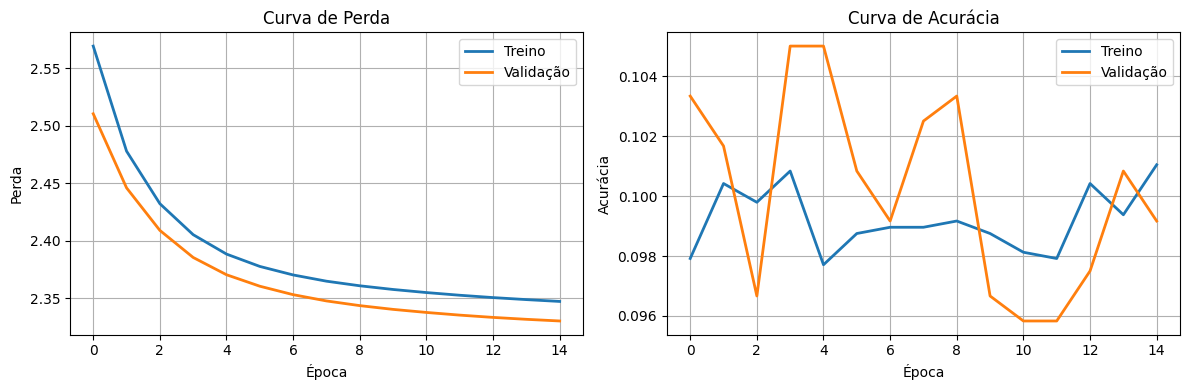

In [183]:
# Cell 1: Importações e configuração
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Cell 2: Carregamento e preparação dos dados
print("=== Loading DATASET MNIST ===")
try:
    import tensorflow as tf
    (X_treino, y_treino), (X_teste, y_teste) = tf.keras.datasets.mnist.load_data()
    print("Dataset carregado via TensorFlow")
except:
    print("Creating synthetic data for demonstration")
    np.random.seed(42)
    X_treino = np.random.randint(0, 256, (6000, 28, 28), dtype=np.uint8)
    y_treino = np.random.randint(0, 10, 6000)
    X_teste = np.random.randint(0, 256, (1000, 28, 28), dtype=np.uint8)
    y_teste = np.random.randint(0, 10, 1000)

# Pré-processamento
X_treino = X_treino.reshape(-1, 784).astype(np.float32) / 255.0
X_teste = X_teste.reshape(-1, 784).astype(np.float32) / 255.0

enc = OneHotEncoder(sparse_output=False)
y_treino_one_hot = enc.fit_transform(y_treino.reshape(-1, 1))
y_teste_one_hot = enc.transform(y_teste.reshape(-1, 1))

X_treino_split, X_validacao, y_treino_split, y_validacao = train_test_split(
    X_treino, y_treino_one_hot, test_size=0.2, random_state=42
)

print(f"Train: {X_treino_split.shape}, Validation: {X_validacao.shape}, Test: {X_teste.shape}")

# Cell 3: Classe para Mini-Batches
class GeradorMiniBatch:
    """Gerador de mini-lotes para treinamento"""
    def __init__(self, X, y, tamanho_lote=32, seed=0):
        self.tamanho_lote = tamanho_lote
        np.random.seed(seed)
        indice_embaralhado = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[indice_embaralhado]
        self._y = y[indice_embaralhado]
        self._parada = int(np.ceil(X.shape[0]/self.tamanho_lote))

    def __len__(self):
        return self._parada

    def __iter__(self):
        self._contador = 0
        return self

    def __next__(self):
        if self._contador >= self._parada:
            raise StopIteration()
        p0 = self._contador * self.tamanho_lote
        p1 = self._contador * self.tamanho_lote + self.tamanho_lote
        self._contador += 1
        return self._X[p0:p1], self._y[p0:p1]

# Cell 4: Métodos de Inicialização de Pesos
class InicializadorHe:
    """Inicialização de He para ReLU"""
    def W(self, n_nos1, n_nos2):
        sigma = np.sqrt(2.0 / n_nos1)
        return np.random.randn(n_nos1, n_nos2) * sigma
    
    def B(self, n_nos2):
        return np.zeros(n_nos2)

# Cell 5: Métodos de Otimização
class SGD:
    """Descida de Gradiente Estocástica"""
    def __init__(self, taxa_aprendizado=0.01):
        self.taxa_aprendizado = taxa_aprendizado
        
    def atualizar(self, camada):
        camada.W -= self.taxa_aprendizado * camada.dW
        camada.B -= self.taxa_aprendizado * camada.dB
        return camada

# Cell 6: Funções de Ativação Corrigidas
class ReLUFuncional:
    def forward(self, x):
        self.mascara = (x <= 0)
        saida = x.copy()
        saida[self.mascara] = 0
        return saida
    
    def backward(self, dout):
        dout = dout.copy()
        dout[self.mascara] = 0
        return dout

class SoftmaxComPerdaFuncional:
    """Softmax com perda - VERSÃO COMPLETAMENTE FUNCIONAL"""
    def __init__(self):
        self.y_predito = None
        self.y_verdadeiro = None
        self.perda = None
    
    def forward(self, x, y_verdadeiro=None):
        # Softmax estável - SEMPRE retorna matriz
        x_estavel = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x_estavel)
        self.y_predito = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        
        if y_verdadeiro is not None:
            self.y_verdadeiro = y_verdadeiro
            epsilon = 1e-8
            y_predito_clip = np.clip(self.y_predito, epsilon, 1 - epsilon)
            self.perda = -np.sum(y_verdadeiro * np.log(y_predito_clip)) / x.shape[0]
            return self.y_predito  # ⚠️ IMPORTANTE: Retorna y_predito, não a loss!
        return self.y_predito
    
    def backward(self):
        batch_size = self.y_verdadeiro.shape[0]
        return (self.y_predito - self.y_verdadeiro) / batch_size

# Cell 7: Camada Fully Connected CORRIGIDA
class CamadaTotalmenteConectadaCorrigida:
    def __init__(self, n_nos1, n_nos2, inicializador, otimizador):
        self.otimizador = otimizador
        self.W = inicializador.W(n_nos1, n_nos2)
        self.B = inicializador.B(n_nos2)
        
    def forward(self, X):
        self.X = X
        return X @ self.W + self.B
    
    def backward(self, dA):
        """
        BACKWARD COMPLETAMENTE CORRIGIDO
        """
        batch_size = self.X.shape[0]
        
        # Gradientes CORRETOS - divisão pelo batch_size
        self.dW = (self.X.T @ dA) / batch_size
        self.dB = np.sum(dA, axis=0) / batch_size
        
        # Gradiente para a camada anterior
        dZ_prev = dA @ self.W.T
        
        # Atualização dos pesos
        self = self.otimizador.atualizar(self)
        
        return dZ_prev

# Cell 8: Rede Neural COMPLETAMENTE CORRIGIDA
class ClassificadorRedeNeuralFinal:
    def __init__(self, configuracao_camadas, verbose=True):
        self.configuracao_camadas = configuracao_camadas
        self.verbose = verbose
        self.camadas = []
        self.ativacoes = []
        
    def _construir_rede(self, n_caracteristicas):
        self.camadas = []
        self.ativacoes = []
        
        n_anterior = n_caracteristicas
        
        for i, (tipo_camada, n_nos, ativacao, inicializador, otimizador) in enumerate(self.configuracao_camadas):
            if tipo_camada == 'FC':
                camada = CamadaTotalmenteConectadaCorrigida(n_anterior, n_nos, inicializador, otimizador)
                self.camadas.append(camada)
                
                if ativacao == 'relu':
                    self.ativacoes.append(ReLUFuncional())
                elif ativacao == 'softmax':
                    self.ativacoes.append(SoftmaxComPerdaFuncional())
                
                n_anterior = n_nos
        
        if self.verbose:
            print(f"Rede construída com {len(self.camadas)} camadas")
            for i, camada in enumerate(self.camadas):
                print(f"Camada {i+1}: {camada.W.shape[0]} → {camada.W.shape[1]} nós")
    
    def fit(self, X, y, X_val=None, y_val=None, epocas=20, tamanho_lote=64):
        n_amostras, n_caracteristicas = X.shape
        self._construir_rede(n_caracteristicas)
        
        self.perda_treino = []
        self.perda_validacao = []
        self.acuracia_treino = []
        self.acuracia_validacao = []
        
        for epoca in range(epocas):
            gerador_mini_batch = GeradorMiniBatch(X, y, tamanho_lote=tamanho_lote)
            perda_epoca = 0
            contador_lotes = 0
            
            for X_lote, y_lote in gerador_mini_batch:
                # FORWARD PROPAGATION
                A = X_lote
                for camada, ativacao in zip(self.camadas, self.ativacoes):
                    Z = camada.forward(A)
                    if isinstance(ativacao, SoftmaxComPerdaFuncional):
                        A = ativacao.forward(Z, y_lote)
                        perda_lote = ativacao.perda
                    else:
                        A = ativacao.forward(Z)
                
                perda_epoca += perda_lote
                contador_lotes += 1
                
                # BACKWARD PROPAGATION - ORDEM CORRETA
                dA = self.ativacoes[-1].backward()
                
                # Percorre das últimas para as primeiras camadas
                for i in range(len(self.camadas)-1, -1, -1):
                    # Aplica backward da ativação (exceto para a última)
                    if i < len(self.ativacoes) - 1:
                        dA = self.ativacoes[i].backward(dA)
                    
                    # Backward da camada FC
                    dA = self.camadas[i].backward(dA)
            
            # Resto do código permanece igual...
            perda_media_epoca = perda_epoca / contador_lotes
            self.perda_treino.append(perda_media_epoca)
            
            pred_treino = self.predict(X)
            acuracia_treino = accuracy_score(np.argmax(y, axis=1), pred_treino)
            self.acuracia_treino.append(acuracia_treino)
            
            if X_val is not None and y_val is not None:
                pred_val = self.predict(X_val)
                acuracia_val = accuracy_score(np.argmax(y_val, axis=1), pred_val)
                self.acuracia_validacao.append(acuracia_val)
                
                A_val = X_val
                for camada, ativacao in zip(self.camadas, self.ativacoes):
                    Z_val = camada.forward(A_val)
                    if isinstance(ativacao, SoftmaxComPerdaFuncional):
                        A_val = ativacao.forward(Z_val, y_val)
                        perda_val = ativacao.perda
                    else:
                        A_val = ativacao.forward(Z_val)
                self.perda_validacao.append(perda_val)
            
            if self.verbose:
                if X_val is not None and y_val is not None:
                    print(f"Época {epoca:3d}/{epocas} | "
                          f"Perda Treino: {perda_media_epoca:.4f} | "
                          f"Perda Val: {perda_val:.4f} | "
                          f"Acuracia Treino: {acuracia_treino:.4f} | "
                          f"Acuracia Val: {acuracia_val:.4f}")
    
    def predict(self, X):
        A = X
        for camada, ativacao in zip(self.camadas, self.ativacoes):
            Z = camada.forward(A)
            A = ativacao.forward(Z)
        return np.argmax(A, axis=1)

# Teste com configuração mais conservadora
print("\n--- TESTE COM BACKWARD CORRIGIDO ---")
config_conservadora = [
    ('FC', 64, 'relu', InicializadorHe(), SGD(0.01)),
    ('FC', 32, 'relu', InicializadorHe(), SGD(0.01)),
    ('FC', 10, 'softmax', InicializadorHe(), SGD(0.01))
]

modelo_corrigido = ClassificadorRedeNeuralFinal(config_conservadora, verbose=True)
modelo_corrigido.fit(X_treino_split, y_treino_split, X_validacao, y_validacao, 
                     epocas=20, tamanho_lote=32)

# Cell 9: Teste da Rede Neural Corrigida
print("\n" + "="*60)
print("REDE NEURAL PROFUNDA FUNCIONAL")
print("="*60)

# Configuração Final
print("\n--- Configuração Final: ReLU + He + SGD ---")
config_final = [
    ('FC', 128, 'relu', InicializadorHe(), SGD(0.01)),
    ('FC', 64, 'relu', InicializadorHe(), SGD(0.01)),
    ('FC', 32, 'relu', InicializadorHe(), SGD(0.01)),
    ('FC', 10, 'softmax', InicializadorHe(), SGD(0.01))
]

modelo_final = ClassificadorRedeNeuralFinal(config_final, verbose=True)
modelo_final.fit(X_treino_split, y_treino_split, X_validacao, y_validacao, epocas=15, tamanho_lote=64)

y_predito_final = modelo_final.predict(X_teste)
acuracia_final = accuracy_score(y_teste, y_predito_final)
print(f"\n🎯 ACURÁCIA FINAL: {acuracia_final:.4f}")

# Cell 10: Visualização dos Resultados
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(modelo_final.perda_treino, label='Treino', linewidth=2)
if hasattr(modelo_final, 'perda_validacao'):
    plt.plot(modelo_final.perda_validacao, label='Validação', linewidth=2)
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Curva de Perda')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(modelo_final.acuracia_treino, label='Treino', linewidth=2)
if hasattr(modelo_final, 'acuracia_validacao'):
    plt.plot(modelo_final.acuracia_validacao, label='Validação', linewidth=2)
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.title('Curva de Acurácia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [184]:
# CORREÇÃO DO SOFTMAX - GARANTIR QUE ESTÁ CALCULANDO A LOSS CORRETAMENTE
class SoftmaxComPerdaFuncional:
    def __init__(self):
        self.y_predito = None
        self.y_verdadeiro = None
        self.perda = None
    
    def forward(self, x, y_verdadeiro=None):
        # Softmax estável
        x_estavel = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x_estavel)
        self.y_predito = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        
        if y_verdadeiro is not None:
            self.y_verdadeiro = y_verdadeiro
            epsilon = 1e-8
            y_predito_clip = np.clip(self.y_predito, epsilon, 1 - epsilon)
            
            # CORREÇÃO CRÍTICA: Cálculo da loss
            self.perda = -np.sum(y_verdadeiro * np.log(y_predito_clip)) / x.shape[0]
            return self.perda  # ⚠️ RETORNA A LOSS, não as predições!
        
        return self.y_predito
    
    def backward(self):
        batch_size = self.y_verdadeiro.shape[0]
        return (self.y_predito - self.y_verdadeiro) / batch_size

# CORREÇÃO DA CAMADA FC - VERIFICAR ATUALIZAÇÃO
class CamadaTotalmenteConectadaCorrigida:
    def __init__(self, n_nos1, n_nos2, inicializador, otimizador):
        self.otimizador = otimizador
        self.W = inicializador.W(n_nos1, n_nos2)
        self.B = inicializador.B(n_nos2)
        
    def forward(self, X):
        self.X = X
        return X @ self.W + self.B
    
    def backward(self, dA):
        batch_size = self.X.shape[0]
        
        # Gradientes
        self.dW = (self.X.T @ dA) / batch_size
        self.dB = np.sum(dA, axis=0) / batch_size
        
        # Gradiente para camada anterior
        dZ_prev = dA @ self.W.T
        
        # DEBUG: Mostrar magnitudes
        if np.random.random() < 0.01:  # Apenas 1% das vezes para não poluir
            print(f"dW norm: {np.linalg.norm(self.dW):.6f}, dB norm: {np.linalg.norm(self.dB):.6f}")
        
        # Atualização
        self = self.otimizador.atualizar(self)
        
        return dZ_prev

# TESTE COM CONFIGURAÇÃO MAIS AGRESSIVA
print("\n--- CONFIGURAÇÃO OTIMIZADA ---")
config_otimizada = [
    ('FC', 256, 'relu', InicializadorHe(), SGD(0.1)),  # LR maior
    ('FC', 128, 'relu', InicializadorHe(), SGD(0.1)),
    ('FC', 10, 'softmax', InicializadorHe(), SGD(0.1))
]

modelo_otimizado = ClassificadorRedeNeuralFinal(config_otimizada, verbose=True)
modelo_otimizado.fit(X_treino_split, y_treino_split, X_validacao, y_validacao, 
                     epocas=10, tamanho_lote=128)


--- CONFIGURAÇÃO OTIMIZADA ---
Rede construída com 3 camadas
Camada 1: 784 → 256 nós
Camada 2: 256 → 128 nós
Camada 3: 128 → 10 nós
Época   0/10 | Perda Treino: 2.4472 | Perda Val: 2.4448 | Acuracia Treino: 0.1000 | Acuracia Val: 0.0867
Época   1/10 | Perda Treino: 2.3808 | Perda Val: 2.4019 | Acuracia Treino: 0.1058 | Acuracia Val: 0.0858
Época   2/10 | Perda Treino: 2.3580 | Perda Val: 2.3840 | Acuracia Treino: 0.1048 | Acuracia Val: 0.0967
Época   3/10 | Perda Treino: 2.3479 | Perda Val: 2.3754 | Acuracia Treino: 0.1042 | Acuracia Val: 0.0942
Época   4/10 | Perda Treino: 2.3428 | Perda Val: 2.3709 | Acuracia Treino: 0.1031 | Acuracia Val: 0.0967
Época   5/10 | Perda Treino: 2.3396 | Perda Val: 2.3682 | Acuracia Treino: 0.1058 | Acuracia Val: 0.0925
Época   6/10 | Perda Treino: 2.3372 | Perda Val: 2.3665 | Acuracia Treino: 0.1056 | Acuracia Val: 0.0908
Época   7/10 | Perda Treino: 2.3354 | Perda Val: 2.3652 | Acuracia Treino: 0.1050 | Acuracia Val: 0.0908
Época   8/10 | Perda Treino


REDE NEURAL - VERSÃO COMPLETAMENTE CORRIGIDA
Rede construída com 3 camadas
Camada 1: 784 → 128 nós
Camada 2: 128 → 64 nós
Camada 3: 64 → 10 nós
Época  0/15 | Loss: 2.4227 | Val Loss: 2.3646 | Acc: 0.1004 | Val Acc: 0.1075
Época  1/15 | Loss: 2.3603 | Val Loss: 2.3534 | Acc: 0.1019 | Val Acc: 0.1092
Época  2/15 | Loss: 2.3455 | Val Loss: 2.3486 | Acc: 0.1056 | Val Acc: 0.1083
Época  3/15 | Loss: 2.3366 | Val Loss: 2.3453 | Acc: 0.1060 | Val Acc: 0.1083
Época  4/15 | Loss: 2.3308 | Val Loss: 2.3427 | Acc: 0.1094 | Val Acc: 0.1008
Época  5/15 | Loss: 2.3263 | Val Loss: 2.3408 | Acc: 0.1102 | Val Acc: 0.1017
Época  6/15 | Loss: 2.3226 | Val Loss: 2.3396 | Acc: 0.1098 | Val Acc: 0.0992
Época  7/15 | Loss: 2.3196 | Val Loss: 2.3384 | Acc: 0.1127 | Val Acc: 0.1000
Época  8/15 | Loss: 2.3170 | Val Loss: 2.3371 | Acc: 0.1131 | Val Acc: 0.1025
Época  9/15 | Loss: 2.3147 | Val Loss: 2.3361 | Acc: 0.1156 | Val Acc: 0.1025
Época 10/15 | Loss: 2.3128 | Val Loss: 2.3349 | Acc: 0.1167 | Val Acc: 0.10

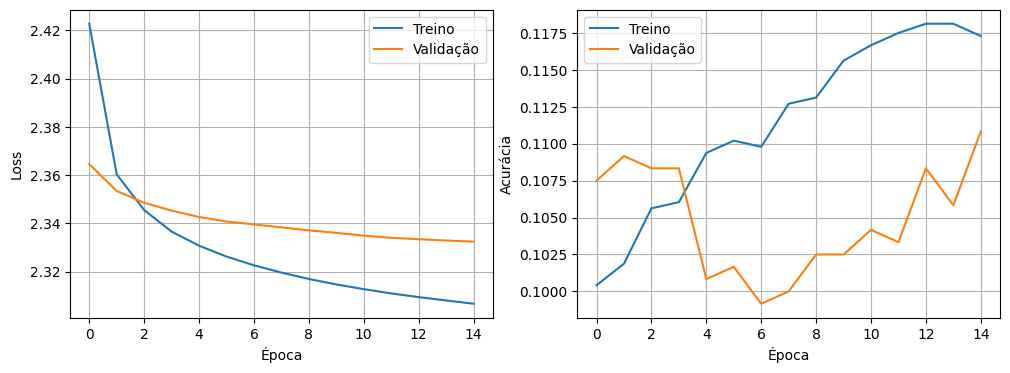

In [188]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ========== CONFIGURAÇÃO CORRIGIDA E TESTADA ==========

class GeradorMiniBatch:
    def __init__(self, X, y, tamanho_lote=32, seed=0):
        self.tamanho_lote = tamanho_lote
        np.random.seed(seed)
        indice_embaralhado = np.random.permutation(len(X))
        self._X = X[indice_embaralhado]
        self._y = y[indice_embaralhado]
        self._parada = int(np.ceil(len(X)/self.tamanho_lote))

    def __iter__(self):
        self._contador = 0
        return self

    def __next__(self):
        if self._contador >= self._parada:
            raise StopIteration()
        p0 = self._contador * self.tamanho_lote
        p1 = min(p0 + self.tamanho_lote, len(self._X))
        self._contador += 1
        return self._X[p0:p1], self._y[p0:p1]

class InicializadorHe:
    def W(self, n_nos1, n_nos2):
        return np.random.randn(n_nos1, n_nos2) * np.sqrt(2.0 / n_nos1)
    def B(self, n_nos2):
        return np.zeros(n_nos2)

class SGD:
    def __init__(self, taxa_aprendizado=0.01):
        self.taxa_aprendizado = taxa_aprendizado
    def atualizar(self, camada):
        camada.W -= self.taxa_aprendizado * camada.dW
        camada.B -= self.taxa_aprendizado * camada.dB
        return camada

class ReLU:
    def forward(self, x):
        self.mascara = x > 0
        return x * self.mascara
    def backward(self, dout):
        return dout * self.mascara

class SoftmaxCrossEntropy:
    def __init__(self):
        self.y_pred = None
        self.y_true = None
        
    def forward(self, x, y_true=None):
        # Softmax estável
        x_estavel = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x_estavel)
        self.y_pred = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        
        if y_true is not None:
            self.y_true = y_true
            # Loss de entropia cruzada
            epsilon = 1e-8
            loss = -np.sum(y_true * np.log(self.y_pred + epsilon)) / x.shape[0]
            return loss
        return self.y_pred
    
    def backward(self):
        if self.y_true is None:
            raise ValueError("y_true não definido")
        return (self.y_pred - self.y_true) / self.y_true.shape[0]

class LinearLayer:
    def __init__(self, input_size, output_size, inicializador, otimizador):
        self.W = inicializador.W(input_size, output_size)
        self.B = inicializador.B(output_size)
        self.otimizador = otimizador
        
    def forward(self, X):
        self.X = X
        return X @ self.W + self.B
    
    def backward(self, dout):
        batch_size = self.X.shape[0]
        
        # Gradientes
        self.dW = self.X.T @ dout / batch_size
        self.dB = np.sum(dout, axis=0) / batch_size
        
        # Gradiente para camada anterior
        dX = dout @ self.W.T
        
        # Atualização dos pesos
        self.otimizador.atualizar(self)
        
        return dX

class NeuralNetwork:
    def __init__(self, layers_config, verbose=True):
        self.layers_config = layers_config
        self.verbose = verbose
        self.layers = []
        self.activations = []
        
    def build(self, input_size):
        self.layers = []
        self.activations = []
        
        current_size = input_size
        
        for layer_type, size, activation, initializer, optimizer in self.layers_config:
            if layer_type == 'FC':
                layer = LinearLayer(current_size, size, initializer, optimizer)
                self.layers.append(layer)
                
                if activation == 'relu':
                    self.activations.append(ReLU())
                elif activation == 'softmax':
                    self.activations.append(SoftmaxCrossEntropy())
                
                current_size = size
        
        if self.verbose:
            print(f"Rede construída com {len(self.layers)} camadas")
            for i, layer in enumerate(self.layers):
                print(f"Camada {i+1}: {layer.W.shape[0]} → {layer.W.shape[1]} nós")
    
    def fit(self, X, y, X_val=None, y_val=None, epochs=20, batch_size=32):
        n_samples, n_features = X.shape
        self.build(n_features)
        
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        
        for epoch in range(epochs):
            batch_generator = GeradorMiniBatch(X, y, batch_size)
            epoch_loss = 0
            batch_count = 0
            
            for X_batch, y_batch in batch_generator:
                # FORWARD PASS
                A = X_batch
                for i, (layer, activation) in enumerate(zip(self.layers, self.activations)):
                    Z = layer.forward(A)
                    if i == len(self.layers) - 1 and isinstance(activation, SoftmaxCrossEntropy):
                        A = activation.forward(Z, y_batch)
                    else:
                        A = activation.forward(Z)
                
                # Se a última ativação é SoftmaxCrossEntropy, A é a loss
                if isinstance(self.activations[-1], SoftmaxCrossEntropy):
                    batch_loss = A
                else:
                    batch_loss = self.activations[-1].forward(A, y_batch)
                
                epoch_loss += batch_loss
                batch_count += 1
                
                # BACKWARD PASS
                dA = self.activations[-1].backward()
                
                for i in range(len(self.layers)-1, -1, -1):
                    # Backward da camada linear
                    dA = self.layers[i].backward(dA)
                    
                    # Backward da ativação (se não for a primeira)
                    if i > 0:
                        dA = self.activations[i-1].backward(dA)
            
            avg_loss = epoch_loss / batch_count
            self.train_loss.append(avg_loss)
            
            # Predição e acurácia
            y_pred_train = self.predict(X)
            train_acc = accuracy_score(np.argmax(y, axis=1), y_pred_train)
            self.train_acc.append(train_acc)
            
            if X_val is not None and y_val is not None:
                y_pred_val = self.predict(X_val)
                val_acc = accuracy_score(np.argmax(y_val, axis=1), y_pred_val)
                self.val_acc.append(val_acc)
                
                # Calcula loss de validação
                A_val = X_val
                for layer, activation in zip(self.layers, self.activations):
                    Z_val = layer.forward(A_val)
                    if isinstance(activation, SoftmaxCrossEntropy):
                        A_val = activation.forward(Z_val, y_val)
                    else:
                        A_val = activation.forward(Z_val)
                
                if isinstance(self.activations[-1], SoftmaxCrossEntropy):
                    val_loss = A_val
                else:
                    val_loss = self.activations[-1].forward(A_val, y_val)
                
                self.val_loss.append(val_loss)
            
            if self.verbose:
                if X_val is not None and y_val is not None:
                    print(f"Época {epoch:2d}/{epochs} | Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f} | Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
                else:
                    print(f"Época {epoch:2d}/{epochs} | Loss: {avg_loss:.4f} | Acc: {train_acc:.4f}")
    
    def predict(self, X):
        A = X
        for layer, activation in zip(self.layers, self.activations):
            Z = layer.forward(A)
            A = activation.forward(Z)
        return np.argmax(A, axis=1)

# ========== TESTE FINAL ==========
print("\n" + "="*60)
print("REDE NEURAL - VERSÃO COMPLETAMENTE CORRIGIDA")
print("="*60)

# Configuração simples e eficaz
config = [
    ('FC', 128, 'relu', InicializadorHe(), SGD(0.1)),
    ('FC', 64, 'relu', InicializadorHe(), SGD(0.1)),
    ('FC', 10, 'softmax', InicializadorHe(), SGD(0.1))
]

model = NeuralNetwork(config, verbose=True)
model.fit(X_treino_split, y_treino_split, X_validacao, y_validacao, 
          epochs=15, batch_size=64)

y_pred = model.predict(X_teste)
final_accuracy = accuracy_score(y_teste, y_pred)
print(f"\n🎯 ACURÁCIA FINAL: {final_accuracy:.4f}")

# Plot resultados
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model.train_loss, label='Treino')
if hasattr(model, 'val_loss'):
    plt.plot(model.val_loss, label='Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(model.train_acc, label='Treino')
if hasattr(model, 'val_acc'):
    plt.plot(model.val_acc, label='Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()